In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout, Embedding, GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import EarlyStopping


lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
# nltk.download()

In [51]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test(1).csv")
df_train.drop(["keyword","location"],axis = 1, inplace=True)
df_test.drop(["keyword","location"],axis = 1, inplace=True)

In [53]:
df_train.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


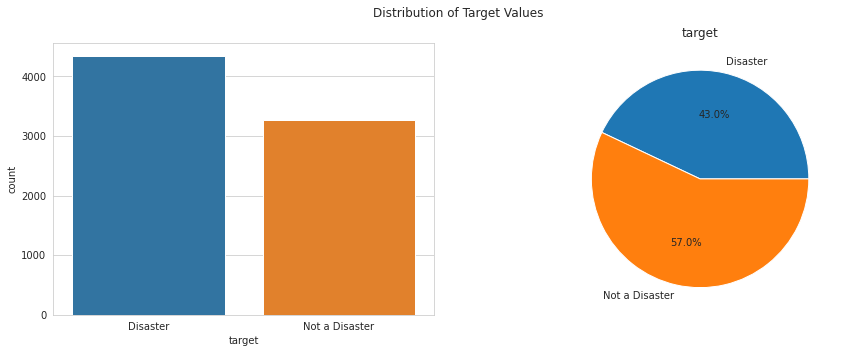

In [4]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='target',data=df_train,label=['Not a Disaster','Disaster'])
ax.set_xticklabels(['Disaster','Not a Disaster'])
plt.suptitle("Distribution of Target Values")
terms = np.array(['Disaster', 'Not a Disaster'])
weigtage = np.array([len(df_train[df_train['target'] == 1]),len(df_train[df_train['target'] == 0])])
plt.subplot(1, 2, 2)
plt.pie(weigtage,labels=terms, autopct="%1.1f%%")
plt.title('target')
plt.show()

In [5]:
df_train["target"].describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

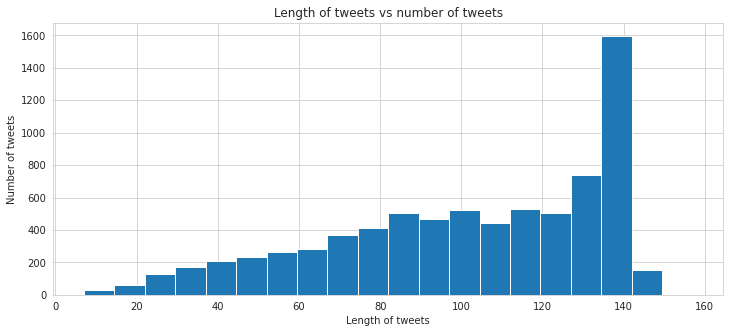

In [6]:
plt.figure(figsize=(12,5))
word_len = df_train["text"].map(lambda x: len(x))
plt.hist(word_len, bins=20)
plt.xlabel("Length of tweets")
plt.ylabel("Number of tweets")
plt.title("Length of tweets vs number of tweets")
plt.show()

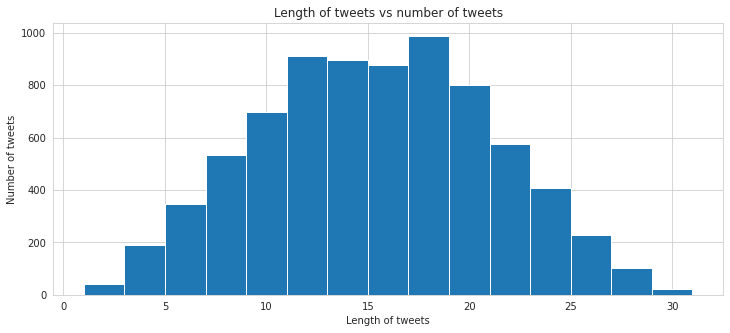

In [7]:
plt.figure(figsize=(12,5))
word_len = df_train["text"].str.split().map(lambda x: len(x))
plt.hist(word_len, bins=15)
plt.xlabel("Length of tweets")
plt.ylabel("Number of tweets")
plt.title("Length of tweets vs number of tweets")
plt.show()

In [8]:
# df_train_modified.groupby("target").head()

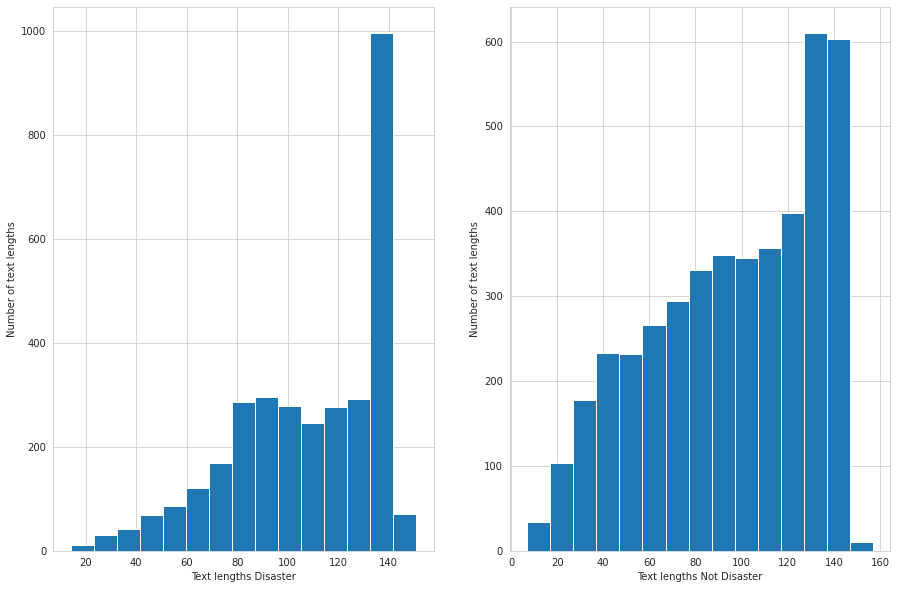

In [9]:
df_train_modified = df_train
len_for_random = len(df_train_modified[df_train_modified["target"] == 0])
df_train_modified["text_len"] = df_train_modified["text"].apply(lambda x: len(x))

plt.figure(figsize=(15,10))
word_len_true = df_train_modified["text_len"].loc[df_train_modified["target"] == 1]
word_len_false = df_train_modified["text_len"].loc[df_train_modified["target"] == 0]
plt.title("Disaster vs no disaster")
plt.subplot(1,2,1)
plt.hist(word_len_true, bins=15)
plt.xlabel("Text lengths Disaster")
plt.ylabel("Number of text lengths")
plt.subplot(1,2,2)
plt.hist(word_len_false, bins=15)
plt.xlabel("Text lengths Not Disaster")
plt.ylabel("Number of text lengths")

plt.show()

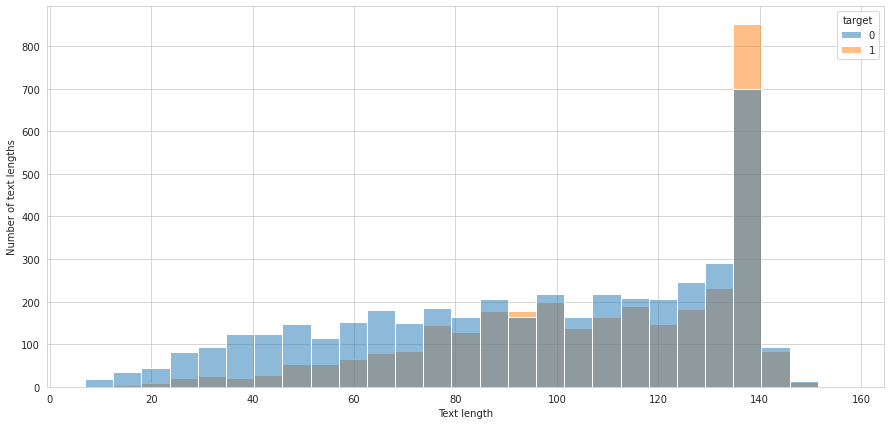

In [10]:
plt.figure(figsize = (15,7))
sns.histplot(data=df_train_modified, x="text_len", hue="target")
plt.xlabel("Text length")
plt.ylabel("Number of text lengths")
plt.show()

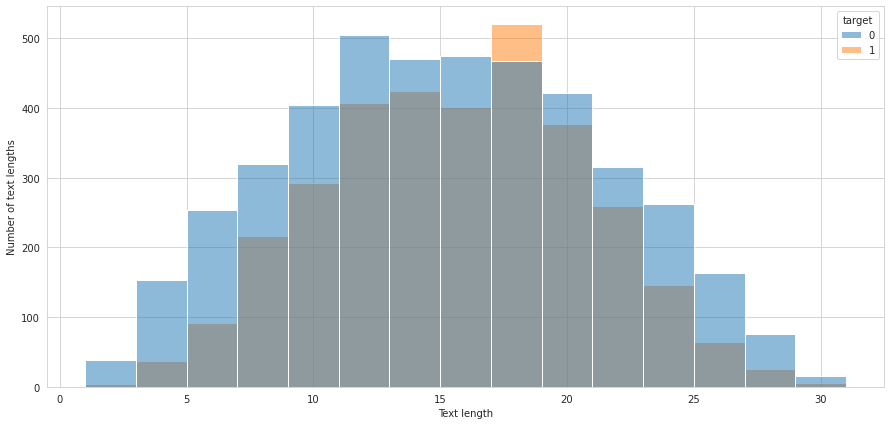

In [11]:
df_train_modified["text_len_word"] = df_train_modified["text"].apply(lambda x: len(x.split()))

plt.figure(figsize = (15,7))
sns.histplot(data=df_train_modified, x="text_len_word", hue="target", bins=15)
plt.xlabel("Text length")
plt.ylabel("Number of text lengths")
plt.show()

In [12]:
# duplicates = df_train[df_train.duplicated(['text','target'],keep=False)]
# df_train.drop(duplicates, inplace=True, axis = 1)

In [13]:
data = pd.concat([df_train, df_test], axis=0,sort=False)
data.drop(['target'],axis=1,inplace=True)
data.head()

,id,text,text_len,text_len_word
0,1,Our Deeds are the Reason of this #earthquake M...,69.0,13.0
1,4,Forest fire near La Ronge Sask. Canada,38.0,7.0
2,5,All residents asked to 'shelter in place' are ...,133.0,22.0
3,6,"13,000 people receive #wildfires evacuation or...",65.0,8.0
4,7,Just got sent this photo from Ruby #Alaska as ...,88.0,16.0


In [14]:
#Removing URL & Special charachtares
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [15]:
df_train["tokens"] = df_train["text"].map(lambda x: preprocess(x))
df_test["tokens"] = df_test["text"].map(lambda x: preprocess(x))
data["tokens"] = data["text"].map(lambda x: preprocess(x))

In [16]:
data.drop(["text_len","text_len_word"], axis = 1, inplace = True)
data.head()

,id,text,tokens
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive
1,4,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,6,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,7,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


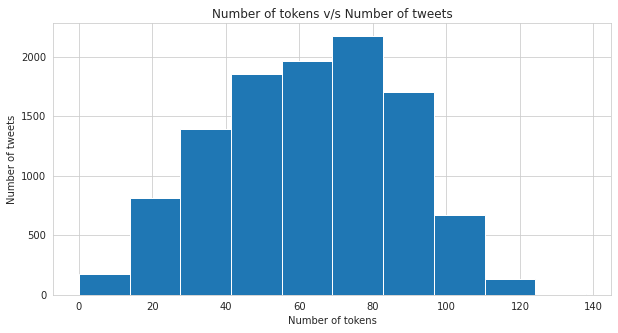

In [17]:
plt.figure(figsize=(10,5))
word_len = data['tokens'].map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Number of tokens')
plt.ylabel('Number of tweets')
plt.title('Number of tokens v/s Number of tweets')
plt.show()

In [18]:
glov_vec_file = open("glove.twitter.27B.100d.txt", encoding="utf8")
embeddings = {}
for line in glov_vec_file:
    values = line.split()
    word = values[0]
    embedding = np.array(values[1:])
    embeddings[word] = embedding
glov_vec_file.close()

In [19]:
def embeddings_out(data,maxlen=20):
    output = np.zeros((data.shape[0],20,100))
    for ix in range(len(data)):
        curr_len = min(maxlen,len(data.iloc[ix]['tokens']))
        for jx in range(curr_len):
            word = str(data.iloc[ix]['tokens'][jx])
            if word in embeddings:
                output[ix][jx] = embeddings[data.iloc[ix]['tokens'][jx]]
    return output

In [20]:
X = embeddings_out(data)
X.shape
data.tail()

,id,text,tokens
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fasteners...
3259,10865,Storm in RI worse than last hurricane. My city...,storm worse last hurricane city amp others har...
3260,10868,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo
3262,10875,#CityofCalgary has activated its Municipal Eme...,cityofcalgary activated municipal emergency pl...


In [141]:
#Creating test and train sets
X_train = X[:int(len(df_train['target'])*0.8)]
X_test = X[int(len(df_train['target'])*0.8):int(len(df_train['target']))]
y_train = df_train[:int(len(df_train['target'].values)*0.8)]['target'].values
y_test = df_train[int(len(df_train['target'].values)*0.8):]['target'].values
len(X_train),len(X_test),len(y_train), len(y_test)


(6090, 1523, 6090, 1523)

In [247]:
def create_model():
    model = Sequential()
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Activation('softmax'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [248]:
model = create_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 20, 64)            42240     
_________________________________________________________________
dropout_42 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
dropout_43 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)              

In [249]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40, min_delta=0)

hist = model.fit(X_train,y_train,epochs=100,batch_size=32,shuffle=True
                 ,validation_split=0.1,callbacks=[early_stop])

Epoch 1/100
172/172 [==============================] - 6s 21ms/step - loss: 0.6851 - accuracy: 0.5691 - val_loss: 0.6850 - val_accuracy: 0.5649
Epoch 2/100
172/172 [==============================] - 3s 18ms/step - loss: 0.6788 - accuracy: 0.5849 - val_loss: 0.6852 - val_accuracy: 0.5649
Epoch 3/100
172/172 [==============================] - 3s 18ms/step - loss: 0.6799 - accuracy: 0.5815 - val_loss: 0.6852 - val_accuracy: 0.5649
Epoch 4/100
172/172 [==============================] - 3s 18ms/step - loss: 0.6784 - accuracy: 0.5860 - val_loss: 0.6852 - val_accuracy: 0.5649
Epoch 5/100
172/172 [==============================] - 3s 18ms/step - loss: 0.6806 - accuracy: 0.5791 - val_loss: 0.6852 - val_accuracy: 0.5649
Epoch 6/100
172/172 [==============================] - 3s 17ms/step - loss: 0.6811 - accuracy: 0.5777 - val_loss: 0.6852 - val_accuracy: 0.5649
Epoch 7/100
172/172 [==============================] - 3s 17ms/step - loss: 0.6761 - accuracy: 0.5930 - val_loss: 0.6851 - val_accuracy:

<AxesSubplot:>

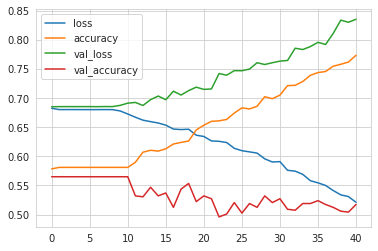

In [250]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [251]:
prediction = model.predict(X_test)

In [252]:
from sklearn.metrics import classification_report

In [253]:
def binaryfy(x):
    if x < 0.5:
        return 0
    else:
        return 1

In [254]:
for i in range(len(prediction)):
    prediction[i] = binaryfy(prediction[i])    

In [255]:
#With patience of 10
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       814
           1       0.60      0.55      0.58       709

    accuracy                           0.62      1523
   macro avg       0.62      0.62      0.62      1523
weighted avg       0.62      0.62      0.62      1523

